(example_2)=
# Non-parametric predictive coding using Dirichlet process nodes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import display
import seaborn as sns
from scipy.stats import multinomial, norm
import jax.numpy as jnp
from functools import partial
from jax import jit
from pyhgf.networks import concatenate_networks, add_coupling
from typing import Dict
from pyhgf.typing import Edges, InputIndexes
from pyhgf.model import HGF
from pyhgf.math import gaussian_surprise

from jax import config
config.update("jax_disable_jit", True)

PyHGF is built on a modular framework that allows working with programmatically pure functions, which means that the structure of the network, as well as the update steps connecting the nodes, are parameters of the belief propagation functions. Most applications of predictive coding neural networks are mostly concerned with the update of the attributes of the network during inference. However, one consequence of this parametrisation is that networks can change their structure during the belief propagation, for example as a function of the prediction errors elicited by the observation. This concept is often referred to as a self-organizing neural network (see for example {cite:p}`Najarro:2023`).

Having a network that can change shape as a function of incoming observations can be a powerful tool if we do not want to parametrise too rigidly our model beforehand, but instead want to let its complexity grow infinitely as observations grow infinitely, a property that is central for nonparametric Bayesian modelling {cite:p}`Gershman2012`. In this notebook, we illustrate how this idea can be applied to create a network that can grow and remove branches and approximates the evolution of a [Dirichlet process](https://en.wikipedia.org/wiki/Dirichlet_process).

## Example 1: Clustering observations from a Gaussian mixture
### Create the dataset

In [2]:
# simulate a dataset
n_trials = 100

def get_value():
    cat = multinomial(n=1, p=[.2, .2, .6]).rvs()
    vals = np.random.normal([0, 2, 4], .2)
    return (cat * vals).sum()

input_data = []
for i in range(n_trials):
    input_data.append(get_value())

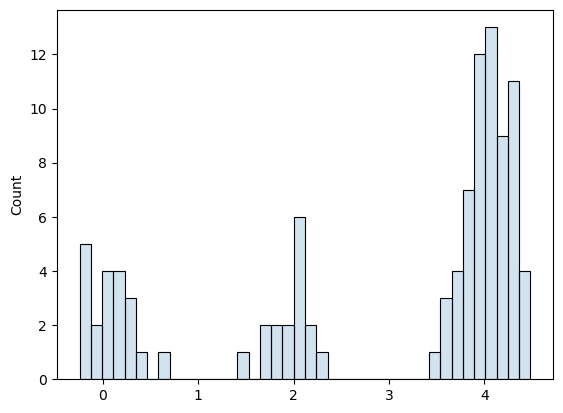

In [3]:
sns.histplot(x=input_data, alpha=.2, bins=40);

### Create the Dirichlet process node
#### The base branch

The first component required by the Dirichlet process node is the base branch. This network has a role similar to the base distribution in the Dirichlet process and should encode the structure of the branch that is duplicated. Here, we start with a simple one-level continuous HGF with both a volatility and value parent. This network will try to learn the mean precision of a latent variable (see also {ref)`Example_2_Input_node_volatility_coupling`).

In [4]:
# create the Dirichlet node structure
base_network = (
    HGF(model_type=None)
    .add_nodes(
        kind="continuous-input", 
        node_parameters={"input_noise": 1.0, "expected_precision": 1.0}
    )
    .add_nodes(
        value_children=0, 
        node_parameters={"tonic_volatility": 0.0, "precision":.5}
    )
    .add_nodes(volatility_children=0)
).set_update_sequence()

Initializing a network with custom node structure.


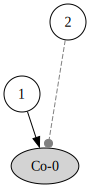

In [5]:
base_network.plot_network()

#### The likelihood function
The second component is the likelihood function of the base network. This function will be used by every branch of the Dirichlet node to compare the likelihood of every new observation. This function should point to the input node(s) of the given branch. Here, the likelihood is simply the Gaussian likelihood given the mean and precision of the underlying distribution.

In [6]:
from jax.scipy.stats.norm import logpdf

def log_likelihood_fn(input_idx, value, attributes, edges):

    value_parent_idx = edges[input_idx].value_parents[0]
    logp = - gaussian_surprise(
        x=value, 
        expected_mean=attributes[value_parent_idx]["mean"],
        expected_precision=attributes[input_idx]["expected_precision"]
    )

    # hyperprior on cluster mean
    logp += logpdf(
        x=attributes[value_parent_idx]["mean"],
        loc=0,
        scale=100,
    )

    return logp

#### The branching function
Finally, the third component of the Dirichlet node is the branching function. This function generates a new branch if no other branch can better explain the new incoming observation. Creating a new branch is a two-step process:
1. Creating the network structure.
2. Parametrizing the attribute of the network.
The first step is straightforward and mainly requires merging a new *base branch* in the network. The second step should decide which priors to use for the new branch, which involves non-trivial arbitrary decisions as - by definition - this new branch has only observed one data point so far.

In [7]:
def parametrize_cluster_fn(input_idx, value, attributes, edges):

    # parametrize a distribution centred on the new value
    value_parent_idx = edges[input_idx].value_parents[0]
    attributes[value_parent_idx]["mean"] = value
    attributes[value_parent_idx]["expected_mean"] = value

    return attributes

In [8]:
import copy

def create_cluster_fn(
    attributes, 
    edges, 
    input_nodes_idx, 
    base_network,
    dirichlet_node,
    dirichlet_node_idx: int = 0
):
    """Create and parametrize a new cluster given a set of observed values"""
    
    base_ = copy.deepcopy(base_network)
    
    network_size = len(attributes)

    # the input indexes for the new branch
    cluster_input_idxs = [idx + network_size for idx in base_.input_nodes_idx.idx]
    new_cluster_input_idxs = dirichlet_node.cluster_input_idxs + tuple(cluster_input_idxs)
    dirichlet_node = dirichlet_node._replace(cluster_input_idxs = new_cluster_input_idxs)

    # merge the new branch with the existing one
    attributes, edges = concatenate_networks(
        attributes_1=base_.attributes, 
        attributes_2=attributes,
        edges_1=base_.edges, 
        edges_2=edges
    )

    # add count for this new cluster
    attributes[dirichlet_node_idx]["n"].append(0)

    # create a new input_nodes variable
    if input_nodes_idx is None:
        input_nodes_idx = base_.input_nodes_idx
    else:
        new_idx = input_nodes_idx.idx
        new_idx += (base_.input_nodes_idx.idx[0] + network_size,)
        
        new_kind = input_nodes_idx.kind
        new_kind += base_.input_nodes_idx.kind
        input_nodes_idx = InputIndexes(new_idx, new_kind)

    # add a value coupling between the Dirichlet node and the branch input(s)
    attributes, edges = add_coupling(
        attributes=attributes, 
        edges=edges,
        kind="value",
        parent_idxs=cluster_input_idxs,
        children_idxs=dirichlet_node_idx
        )

    return attributes, edges, input_nodes_idx, dirichlet_node

#### The Dirichlet process node
Finally, we define the main network with a Dirichlet process as the input node. This input takes the base branch as a template to duplicate later.

In [34]:
# create the Dirichlet node structure
dirichlet_hgf = (
    HGF(model_type=None)
    .add_nodes(
        kind="dirichlet-input", 
        node_parameters={
            "alpha": 0.5,
            "base_network": base_network,
            "create_cluster_fn": create_cluster_fn,
            "log_likelihood_fn": log_likelihood_fn,
            "parametrize_cluster_fn": parametrize_cluster_fn,
        }
    )
)

Initializing a network with custom node structure.


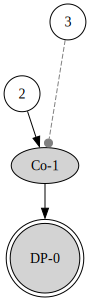

In [35]:
dirichlet_hgf.plot_network()

In [36]:
dirichlet_hgf.set_update_sequence();

### Add observations to the network

In [37]:
for value in input_data[:10]:
    
    for node_idx, update_fn in dirichlet_hgf.update_sequence:

        if "dirichlet" in update_fn.__name__:

            attributes = dirichlet_hgf.attributes
            edges = dirichlet_hgf.edges
            dirichlet_node = dirichlet_hgf.dirichlet_node
            input_nodes_idx = dirichlet_hgf.input_nodes_idx

            attributes, edges, input_nodes_idx, dirichlet_node = update_fn(
                edges=edges,
                attributes=attributes,
                value=value,
                time_step=1.0,
                node_idx=node_idx,
                dirichlet_node=dirichlet_node,
                input_nodes_idx=input_nodes_idx
            )

            dirichlet_hgf.attributes = attributes
            dirichlet_hgf.edges = edges
            dirichlet_hgf.input_nodes_idx = input_nodes_idx
            dirichlet_hgf.dirichlet_node = dirichlet_node

            dirichlet_hgf.set_update_sequence()

        else:
            attributes = dirichlet_hgf.attributes
            edges = dirichlet_hgf.edges

            attributes = update_fn(
                attributes=attributes,
                time_step=1.0,
                node_idx=node_idx,
                edges=edges,
                value=value,
                observed=1.0,
            )

            dirichlet_hgf.attributes = attributes

    print(attributes[1]["expected_precision"])

pi_new: 1.0
pi_cluster: [1.0]
clusters_log_likelihood: [Array(-6.443879, dtype=float32)]
1.0
pi_new: 0.3333333333333333
pi_cluster: [0.6666666666666666, 0.3333333333333333]
clusters_log_likelihood: [Array(-6.4550724, dtype=float32), Array(-6.4439416, dtype=float32)]
0.6010015
pi_new: 0.2
pi_cluster: [0.8, 0.2]
clusters_log_likelihood: [Array(-6.784855, dtype=float32), Array(-6.4437027, dtype=float32)]
0.6913653
pi_new: 0.14285714285714285
pi_cluster: [0.8571428571428571, 0.14285714285714285]
clusters_log_likelihood: [Array(-6.630475, dtype=float32), Array(-6.6983395, dtype=float32)]
0.7277377
pi_new: 0.1111111111111111
pi_cluster: [0.8888888888888888, 0.1111111111111111]
clusters_log_likelihood: [Array(-7.468632, dtype=float32), Array(-6.626089, dtype=float32)]
0.7930606
pi_new: 0.09090909090909091
pi_cluster: [0.9090909090909091, 0.09090909090909091]
clusters_log_likelihood: [Array(-6.9481, dtype=float32), Array(-6.5769854, dtype=float32)]
0.5885725
pi_new: 0.07692307692307693
pi_clus

## Plotting results

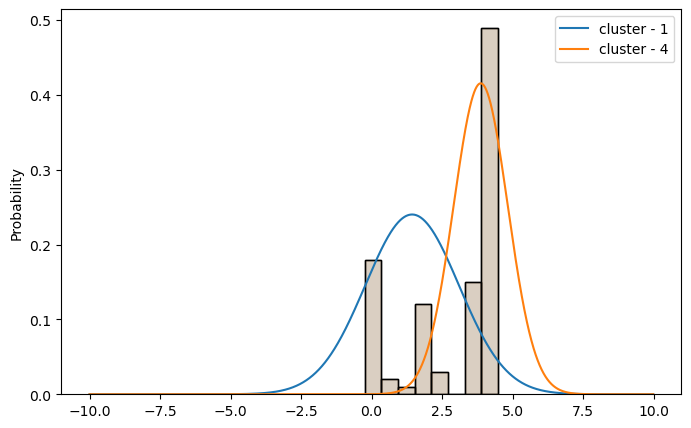

In [38]:
fig, ax = plt.subplots(figsize=(8, 5))
for input_idx in dirichlet_hgf.dirichlet_node.cluster_input_idxs:
    
    value_parent_idx = dirichlet_hgf.edges[input_idx].value_parents[0]
    volatility_parent_idx = dirichlet_hgf.edges[input_idx].volatility_parents[0]

    mean = dirichlet_hgf.attributes[value_parent_idx]['expected_mean']
    
    # the precision of the Gaussian is given by:
    precision = attributes[input_idx]["expected_precision"]

    ax.plot(
        np.arange(-10, 10, .01), 
        norm(loc=mean, scale=np.sqrt(1/precision)).pdf(np.arange(-10, 10, .01)),
        label=f"cluster - {input_idx}"
    )
    sns.histplot(x=input_data, alpha=.2, ax=ax, stat="probability");
plt.legend()
plt.show()

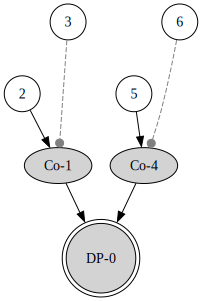

In [33]:
dirichlet_hgf.plot_network()

In [15]:
dirichlet_hgf.dirichlet_node

DirichletNode(base_network=<pyhgf.model.HGF object at 0x7f1dee129a30>, create_cluster_fn=<function create_cluster_fn at 0x7f1e6cd89ca0>, likelihood_fn=<function log_likelihood_fn at 0x7f1dee0910d0>, parametrize_cluster_fn=<function parametrize_cluster_fn at 0x7f1e6cd899d0>, cluster_input_idxs=(1, 4, 7, 10))

In [16]:
dirichlet_hgf.attributes[5]["mean"] = 1.0 

In [23]:
dirichlet_hgf.attributes[2]

{'mean': Array(3.8543472, dtype=float32),
 'expected_mean': Array(4.1554236, dtype=float32),
 'precision': Array(1.2310512, dtype=float32),
 'expected_precision': Array(0.53968596, dtype=float32),
 'volatility_coupling_children': None,
 'volatility_coupling_parents': None,
 'value_coupling_children': (1.0,),
 'value_coupling_parents': None,
 'tonic_volatility': 0.0,
 'tonic_drift': 0.0,
 'autoregressive_coefficient': 0.0,
 'autoregressive_intercept': 0.0,
 'observed': 1,
 'temp': {'effective_precision': Array(0.53968596, dtype=float32),
  'value_prediction_error': 0.0,
  'volatility_prediction_error': 0.0,
  'expected_precision_children': 0.0}}

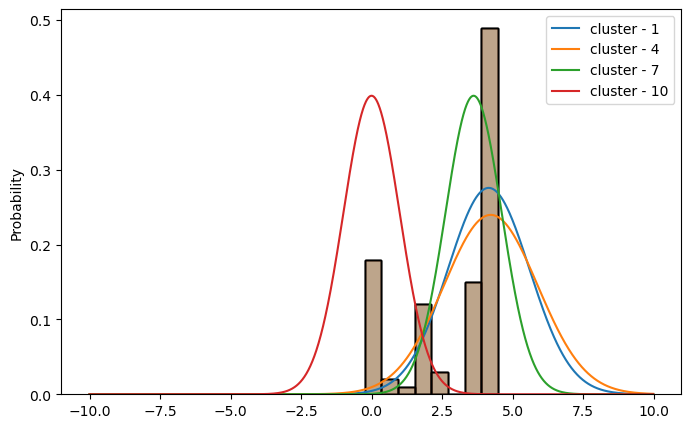

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
for input_idx in dirichlet_hgf.dirichlet_node.cluster_input_idxs:
    
    value_parent_idx = dirichlet_hgf.edges[input_idx].value_parents[0]
    volatility_parent_idx = dirichlet_hgf.edges[input_idx].volatility_parents[0]

    mean = dirichlet_hgf.attributes[value_parent_idx]['expected_mean']
    # the precision of the Gaussian is given by:
    mean_volatility = attributes[volatility_parent_idx]["expected_mean"]
    input_noise = jnp.log(1/attributes[input_idx]["expected_precision"])
    precision = 1 / jnp.exp(input_noise + mean_volatility)

    ax.plot(
        np.arange(-10, 10, .01), 
        norm(loc=mean, scale=np.sqrt(1/precision)).pdf(np.arange(-10, 10, .01)),
        label=f"cluster - {input_idx}"
    )
    sns.histplot(x=input_data, alpha=.2, ax=ax, stat="probability");
plt.legend()
plt.show()

In [19]:
dirichlet_hgf.dirichlet_node.cluster_input_idxs

(1, 4, 7, 10)

## Using a Dirichlet process node

A Dirichlet node has the following parameters:
- $\sigma_\xi$, the default cluster precision.
- $\alpha$, the concentration parameter.
- $\pi_i = \frac{n_i}{\alpha + k - 1}$
- $k$ the current number of clusters
- $n_i$ the number of observations in cluster $C_i$

A Dirichlet process over a measurable set $S$ is specifided by a base distribution $H$ and a concentration parameter $\alpha$. In pyhgf, the base distribution is a tree probabilistic neural network that can operate over $S$. When a new set is observed, the Dirichlet node will chose between the following alternatives:

1. Create a new cluster $C_n$ with probability:
    - $\frac{\alpha}{\alpha + n - 1}p(x|\mu_n, \sigma_n)$
    - with $\mu_n = x$ and $\sigma_n = \sigma_\xi$
2. Merge two cluster $j$ and $k$ into a new cluster $l$ if:
    - $p(x|\mu_l, \sigma_l)\pi_l < p(x|\mu_k, \sigma_k)\pi_k + p(x|\mu_j, \sigma_j)\pi_j$
    - $\mu_l = \frac{\mu_j + \mu_k}{2}$
    - $\sigma_l = \frac{\sigma_j + \sigma_k}{2}$
    - $\pi_l = \frac{n_j + n_k}{\alpha + k - 1}$
3. Otherwise, sample from cluster $C_i$ where:
    - $p(x|\mu_i, \sigma_i)\pi_i \le p(x|\mu_j, \sigma_j)\pi_j \forall j \in C $.

First we start by defining the base distribution $H$. This requires use to detail how the node can create a new distribution, and how to update this distribution. Those steps are declared in the function `base_distribution` and the variable `cluster_updates` (respectively).

fig, ax = plt.subplots();
def update(frame):
    ax.cla()
    sns.histplot(x=input_data[:frame], alpha=.2, bins=40, ax=ax);
    ax.scatter(input_data[frame], -.5, alpha=.5)

animation = FuncAnimation(fig, update, frames=range(len(input_data)), interval=100)
display(HTML(animation.to_jshtml()))

In [120]:
alpha = 1.0
N = np.array([5, 3])
x= np.arange(-10, 10, .01)

y = -3.0
sigma = 1.0

mu_0, sigma_0 = 0, 10

mu_k, sigma_k = np.array([1.0, 3.0]), np.array([1.5, 3.5])

p_mu = []
for mu in x:
    new_evidence = (alpha / (np.sum(N) + alpha)) * norm(loc=mu, scale=sigma).pdf(y) * norm(loc=mu_0, scale=sigma_0).pdf(mu)
    cluster_evidence = np.sum(norm(loc=mu_k, scale=sigma_k).pdf([mu, mu]) * (N / (alpha + N.sum())))
    p_mu.append(new_evidence / cluster_evidence)
p_mu = np.array(p_mu)

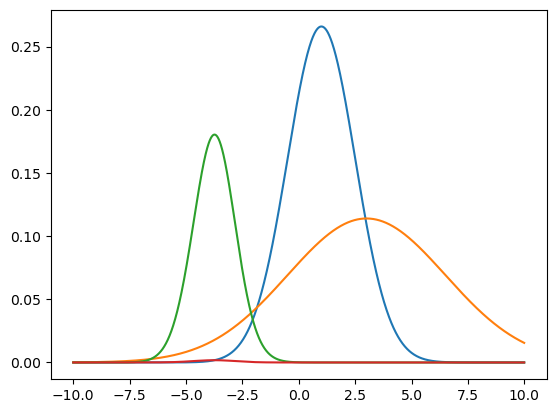

In [121]:
plt.plot(x, norm(loc=mu_k[0], scale=sigma_k[0]).pdf(x))
plt.plot(x, norm(loc=mu_k[1], scale=sigma_k[1]).pdf(x))

plt.plot(x, p_mu)

N = np.array([500, 300])

p_mu = []
for mu in x:
    new_evidence = (alpha / (np.sum(N) + alpha)) * norm(loc=mu, scale=sigma).pdf(y) * norm(loc=mu_0, scale=sigma_0).pdf(mu)
    cluster_evidence = np.sum(norm(loc=mu_k, scale=sigma_k).pdf([mu, mu]) * (N / (alpha + N.sum())))
    p_mu.append(new_evidence / cluster_evidence)
p_mu = np.array(p_mu)

plt.plot(x, p_mu);

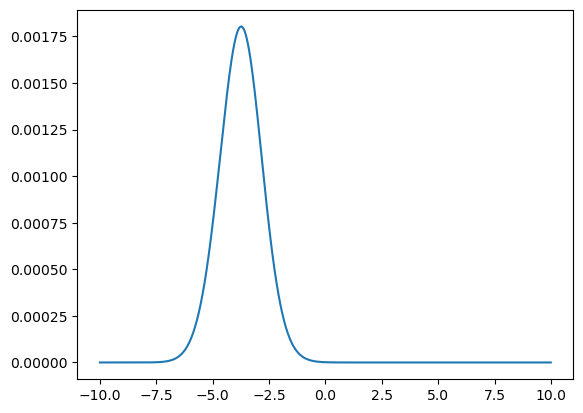

In [122]:
plt.plot(x, p_mu)